In [1]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [2]:
source("../src/filter_sites.R")
source("../src/funciones.R")

suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))

In [3]:
suppressMessages(library(saqgetr))
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(worldmet))

# En lugar de cargar el paquete openair se utiliza el ggopenair,
# otro paquete desarrollado por el mismo que Openair con el objetivo de 
# utilizar ggplot2 en lugar de lattice para la representaciones graficas
#
#suppressMessages(library(openair))
suppressMessages(library(ggopenair)) 


suppressMessages(library(gridExtra))
suppressMessages(library(mblm))

In [4]:
nn.sites <- read.csv("../data/csv/nn_sites.csv")

df <- data.frame()
percent <- c(0.5, 0.7, 0.8, 0.9)

for (nm in names(nn.sites)[6:length(names(nn.sites))]) {
    for (i in 1:length(percent)) {
        count <- sum(nn.sites[, nm] >= percent[i])
        df[i, nm] <- count
    } 
}

row.names(df) <- percent
head(df)

,countMto,ws,wd,air_temp,atmos_pres,visibility,dew_point,RH,ceil_hgt,cl_1,cl_2,cl_3,cl,cl_1_height,cl_2_height,cl_3_height,precip_12,precip,precip_6,pwc
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0.5,159,159,159,159,46,66,159,159,26,44,0,0,44,43,0,0,0,14,0,1
0.7,159,159,142,159,38,33,146,146,3,7,0,0,7,7,0,0,0,14,0,1
0.8,159,152,111,159,38,33,135,135,3,0,0,0,0,0,0,0,0,8,0,1
0.9,159,142,60,151,38,33,133,133,0,0,0,0,0,0,0,0,0,2,0,1


In [5]:
sites <- relevant.sites(sites.fl="../data/csv/nn_sites.csv",
                        cols=1:12,
                        minValue=0.0,
                        percent=0.7,
                        numVar=7,
                        unique.cty=TRUE
                       )
head(sites)

,Municipio,siteAQ,countAQ,siteMto,dist,countMto,ws,wd,air_temp,atmos_pres,visibility,dew_point,numVar
,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
52,Oviedo,es1268a,419493,080150-99999,0.924192,62959,0.9981099,0.9821630,0.9999841,0.9994758,0.9886434,0.9941708,7
26,Ourense,es1096a,405864,080440-99999,61.344307,55321,0.9926429,0.9699752,0.9999819,0.9934564,0.9898411,0.9961859,7
134,Valladolid,es1632a,394858,081410-99999,1.411223,63416,0.9810458,0.9746752,0.9999685,0.9997162,0.9941813,0.9973193,7
29,Vigo,es1137a,396299,080440-99999,25.923040,55321,0.9926429,0.9699752,0.9999819,0.9934564,0.9898411,0.9961859,7
63,Gijón,es1271a,420559,080140-99999,3.136950,16220,0.9996917,0.8863132,0.9999383,0.9996301,0.9996301,0.9996917,7
115,Las Palmas de Gran Canaria,es1573a,355339,600200-99999,87.398704,42552,0.9992715,0.9896127,0.9999060,0.9992480,0.9854766,0.9996945,7


## Abrir los datos de las estacions

In [6]:
read.dataAQ <- function(site) {
    read.csv(paste("../data/csv/dataAQ/",
                   site,".csv",sep=""))
}

read.dataMto <- function(site) {
    read.csv(paste("../data/csv/dataMto/", 
                   site, ".csv", sep=""))
}

In [138]:
numSites = 2

data.all <- data.frame()
#data.all <- vector(mode="list", length=numSites)

for (row in 1:numSites) {
    data.AQ <- read.dataAQ(sites$siteAQ[row])
    data.AQ <- pivot.by.pollut(data.AQ, 
                               levels(as.factor(data.AQ$variable)),
                               by="day",
                               FUN="mean"
                              )
    
    data.AQ <- data.AQ %>% 
                group_by(date)%>%
                summarise(no = mean(no),
                          no2 = mean(no2),
                          o3= mean(o3),
                          pm10= mean(pm10),
                         )
    
    data.Mto <- read.dataMto(sites$siteMto[row])
    data.Mto$date <- round_date(ymd_hms(data.Mto$date), unit="day")
    
    data.Mto <- data.Mto %>% 
                    group_by(date)%>%
                    summarise(
                              ws = mean(ws),
                              wd = mean(wd),
                              air_temp = mean(air_temp),
                              atmos_pres = mean(atmos_pres),
                              visibility = mean(visibility),
                              dew_point = mean(dew_point),
                              RH = mean(RH),
                             )
    
    merged.data <- merge(x=data.AQ, 
                         y=data.Mto, 
                         by="date",all.x=TRUE, all.y=TRUE)
    
    data.all <- rbind(data.all,
                      cbind(data.frame(site=rep(sites$siteAQ[row], 
                                                nrow(merged.data))), 
                            merged.data
                           )
                     )
}

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [139]:
sum(is.na(data.all))
sum(!is.na(data.all))

[1] 3847

[1] 100647

In [141]:
data.all <- data.all[complete.cases(data.all), ]

In [142]:
head(data.all)

,site,date,no,no2,o3,pm10,ws,wd,air_temp,atmos_pres,visibility,dew_point,RH
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,es1268a,2010-01-01,5.506385,14.74362,42.65065,98.60254,2.2250,217.50,4.0000,1001.750,9000.0,-0.2000,74.61477
2,es1268a,2010-01-02,14.126680,31.47500,34.56500,23.44168,2.1250,253.75,7.3750,1013.000,13625.0,1.8125,68.44983
3,es1268a,2010-01-03,32.561583,44.33154,24.46092,23.15168,1.7875,181.25,10.6500,1011.275,16625.0,4.6500,67.19017
4,es1268a,2010-01-04,49.113320,53.30000,13.22334,32.19832,1.8000,191.25,8.0125,1011.150,9375.0,7.1125,94.19572
5,es1268a,2010-01-05,16.000000,38.93168,33.64166,23.27480,2.9500,108.75,7.1375,1005.650,6250.0,5.8500,91.91089
6,es1268a,2010-01-06,11.210125,34.31521,27.87908,28.71429,1.0750,266.25,3.0875,1007.612,8062.5,0.4375,83.58300


In [143]:
sum(is.na(data.all))
sum(!is.na(data.all))

[1] 0

[1] 69706

```R
while(sum(is.na(data.all)) != 0) {
    for (col in 3:ncol(data.all)) {
        for (i in which(is.na(data.all[, col]))) {
            data.all[i, col] <- mean(data.all[i-2:i+2, col], na.rm=TRUE)
        }
    }
    print("1")
}

sum(is.na(data.all))
sum(!is.na(data.all))

```

In [144]:
head(data.all)

,site,date,no,no2,o3,pm10,ws,wd,air_temp,atmos_pres,visibility,dew_point,RH
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,es1268a,2010-01-01,5.506385,14.74362,42.65065,98.60254,2.2250,217.50,4.0000,1001.750,9000.0,-0.2000,74.61477
2,es1268a,2010-01-02,14.126680,31.47500,34.56500,23.44168,2.1250,253.75,7.3750,1013.000,13625.0,1.8125,68.44983
3,es1268a,2010-01-03,32.561583,44.33154,24.46092,23.15168,1.7875,181.25,10.6500,1011.275,16625.0,4.6500,67.19017
4,es1268a,2010-01-04,49.113320,53.30000,13.22334,32.19832,1.8000,191.25,8.0125,1011.150,9375.0,7.1125,94.19572
5,es1268a,2010-01-05,16.000000,38.93168,33.64166,23.27480,2.9500,108.75,7.1375,1005.650,6250.0,5.8500,91.91089
6,es1268a,2010-01-06,11.210125,34.31521,27.87908,28.71429,1.0750,266.25,3.0875,1007.612,8062.5,0.4375,83.58300


In [145]:
cor(scale(data.all[data.all$site == "es1096a", 3:13]), 
    method = "pearson",  #("pearson", "kendall", "spearman")
    #na.rm = TRUE,
    use="na.or.complete" #("everything", "all.obs", "complete.obs", "na.or.complete", "pairwise.complete.obs")
   )

,no,no2,o3,pm10,ws,wd,air_temp,atmos_pres,visibility,dew_point,RH
no,1.0000000,0.58978774,-0.67177052,0.45742327,-0.20703226,-0.335377367,-0.43050270,0.269683168,-0.104346188,-0.3771772,0.12399799
no2,0.5897877,1.00000000,-0.40508718,0.28552105,-0.09834700,-0.292672629,-0.36306845,-0.065145154,-0.242280229,-0.3329079,0.10075250
o3,-0.6717705,-0.40508718,1.00000000,-0.29046238,0.24843994,0.395571524,0.46515633,-0.233631705,0.030681123,0.2589994,-0.36350393
pm10,0.4574233,0.28552105,-0.29046238,1.00000000,-0.09617068,-0.272862176,-0.14409646,0.185077610,0.024165283,-0.1965056,-0.06228914
ws,-0.2070323,-0.09834700,0.24843994,-0.09617068,1.00000000,0.260864434,-0.03133985,-0.167923293,0.118765954,-0.1468676,-0.18240704
wd,-0.3353774,-0.29267263,0.39557152,-0.27286218,0.26086443,1.000000000,0.28354881,-0.008958159,-0.007339486,0.2578085,-0.08096487
air_temp,-0.4305027,-0.36306845,0.46515633,-0.14409646,-0.03133985,0.283548808,1.00000000,-0.113442424,0.119981698,0.8082507,-0.38995647
atmos_pres,0.2696832,-0.06514515,-0.23363170,0.18507761,-0.16792329,-0.008958159,-0.11344242,1.000000000,0.237303454,-0.2332931,-0.19983791
visibility,-0.1043462,-0.24228023,0.03068112,0.02416528,0.11876595,-0.007339486,0.11998170,0.237303454,1.000000000,-0.1879502,-0.52582370
dew_point,-0.3771772,-0.33290787,0.25899944,-0.19650563,-0.14686759,0.257808550,0.80825068,-0.233293099,-0.187950151,1.0000000,0.22104773


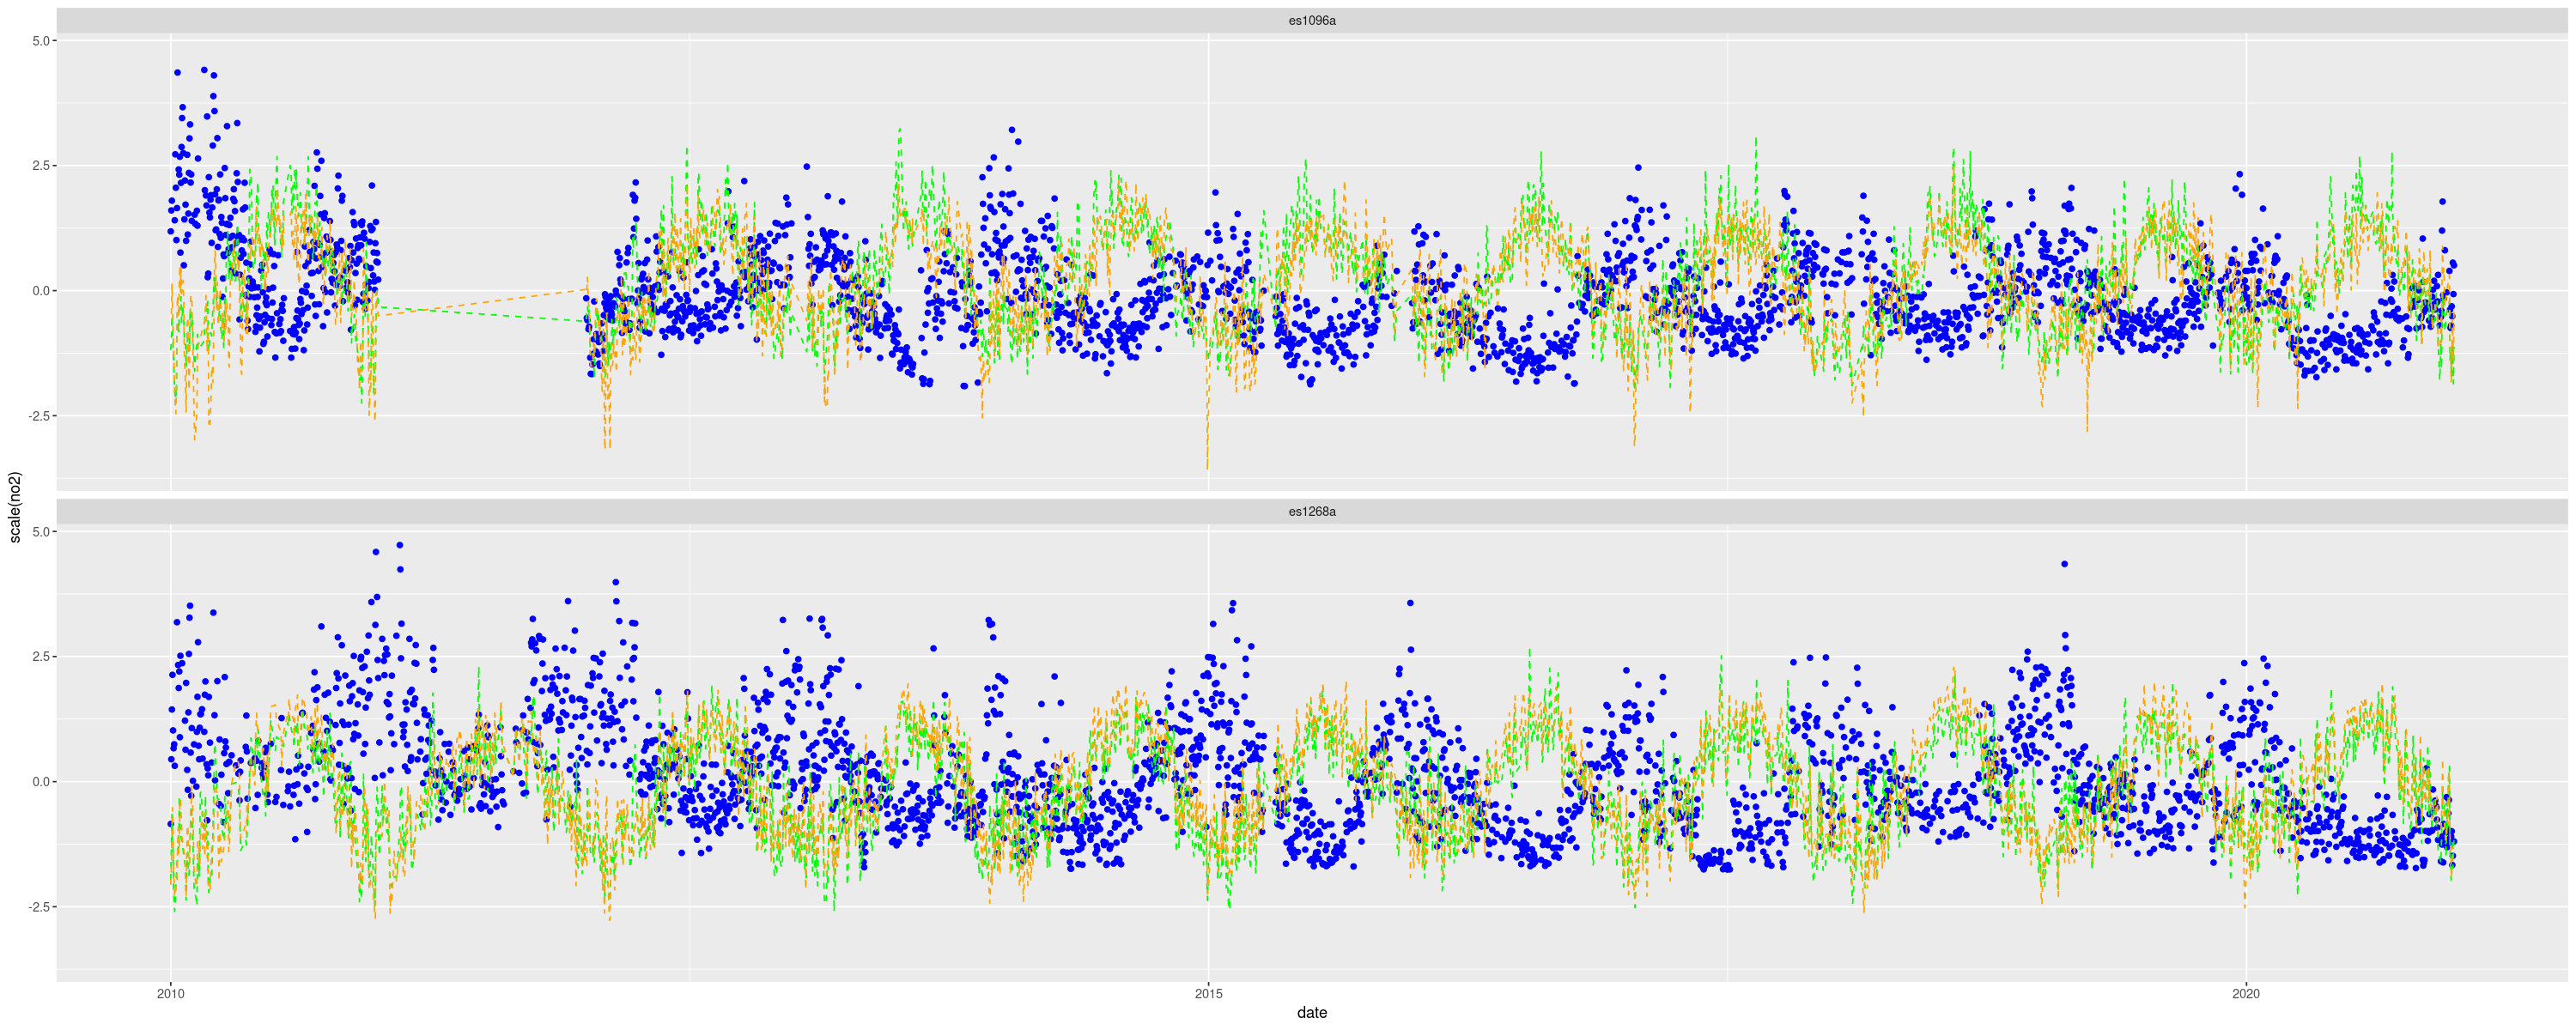

In [146]:
ggplot(data = data.all, aes(x = date), group = names(data.all)) +
    geom_point(aes(y = scale(no2)),       color = "blue")  + 
    geom_line( aes(y = scale(air_temp)),  color="green",     linetype = "dashed") + 
    #geom_line( aes(y = scale(ws)),        color="purple",    linetype = "dashed") + 
    #geom_line( aes(y = scale(wd)),        color="lightblue", linetype = "dashed") + 
    geom_line( aes(y = scale(dew_point)), color="orange",    linetype = "dashed") + 
    facet_wrap(~site, ncol=1)

In [153]:
# 12 mth/yr
# 52.1429 wk/yr
# 366 dy/yt
# 8784 hr/yr
fit <- lm(no2 ~ (sin(2*pi/(52.1429)*(week(date)))   / ws        
                 + cos(2*pi/(52.1429)*(week(date))) / ws
                 + sin(2*pi/(52.1429)*(week(date))) / air_temp  
                 + cos(2*pi/(52.1429)*(week(date))) / air_temp
                 #+ sin(2*pi/(52.1492)*(week(date))) / wd        
                 #+ cos(2*pi/(52.1492)*(week(date))) / wd 
                 #+ sin(2*pi/(52.1492)*(week(date))) / dew_point 
                 #+ cos(2*pi/(52.1492)*(week(date))) / dew_point 
                 ),
          data.all[data.all$site == "es1268a" &
                   data.all$date <= "2020-03-14", ])

In [154]:
y.pre <- predict(fit, newdata=data.all[data.all$site == "es1268a" &
                                   data.all$date <= "2020-03-14", ])

y.drnt <- predict(fit, newdata=data.all[data.all$site == "es1268a" &
                                   data.all$date >= "2020-03-14", ])

ERROR while rich displaying an object: Error: Aesthetics must be either length 1 or the same as the data (2550): y

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.

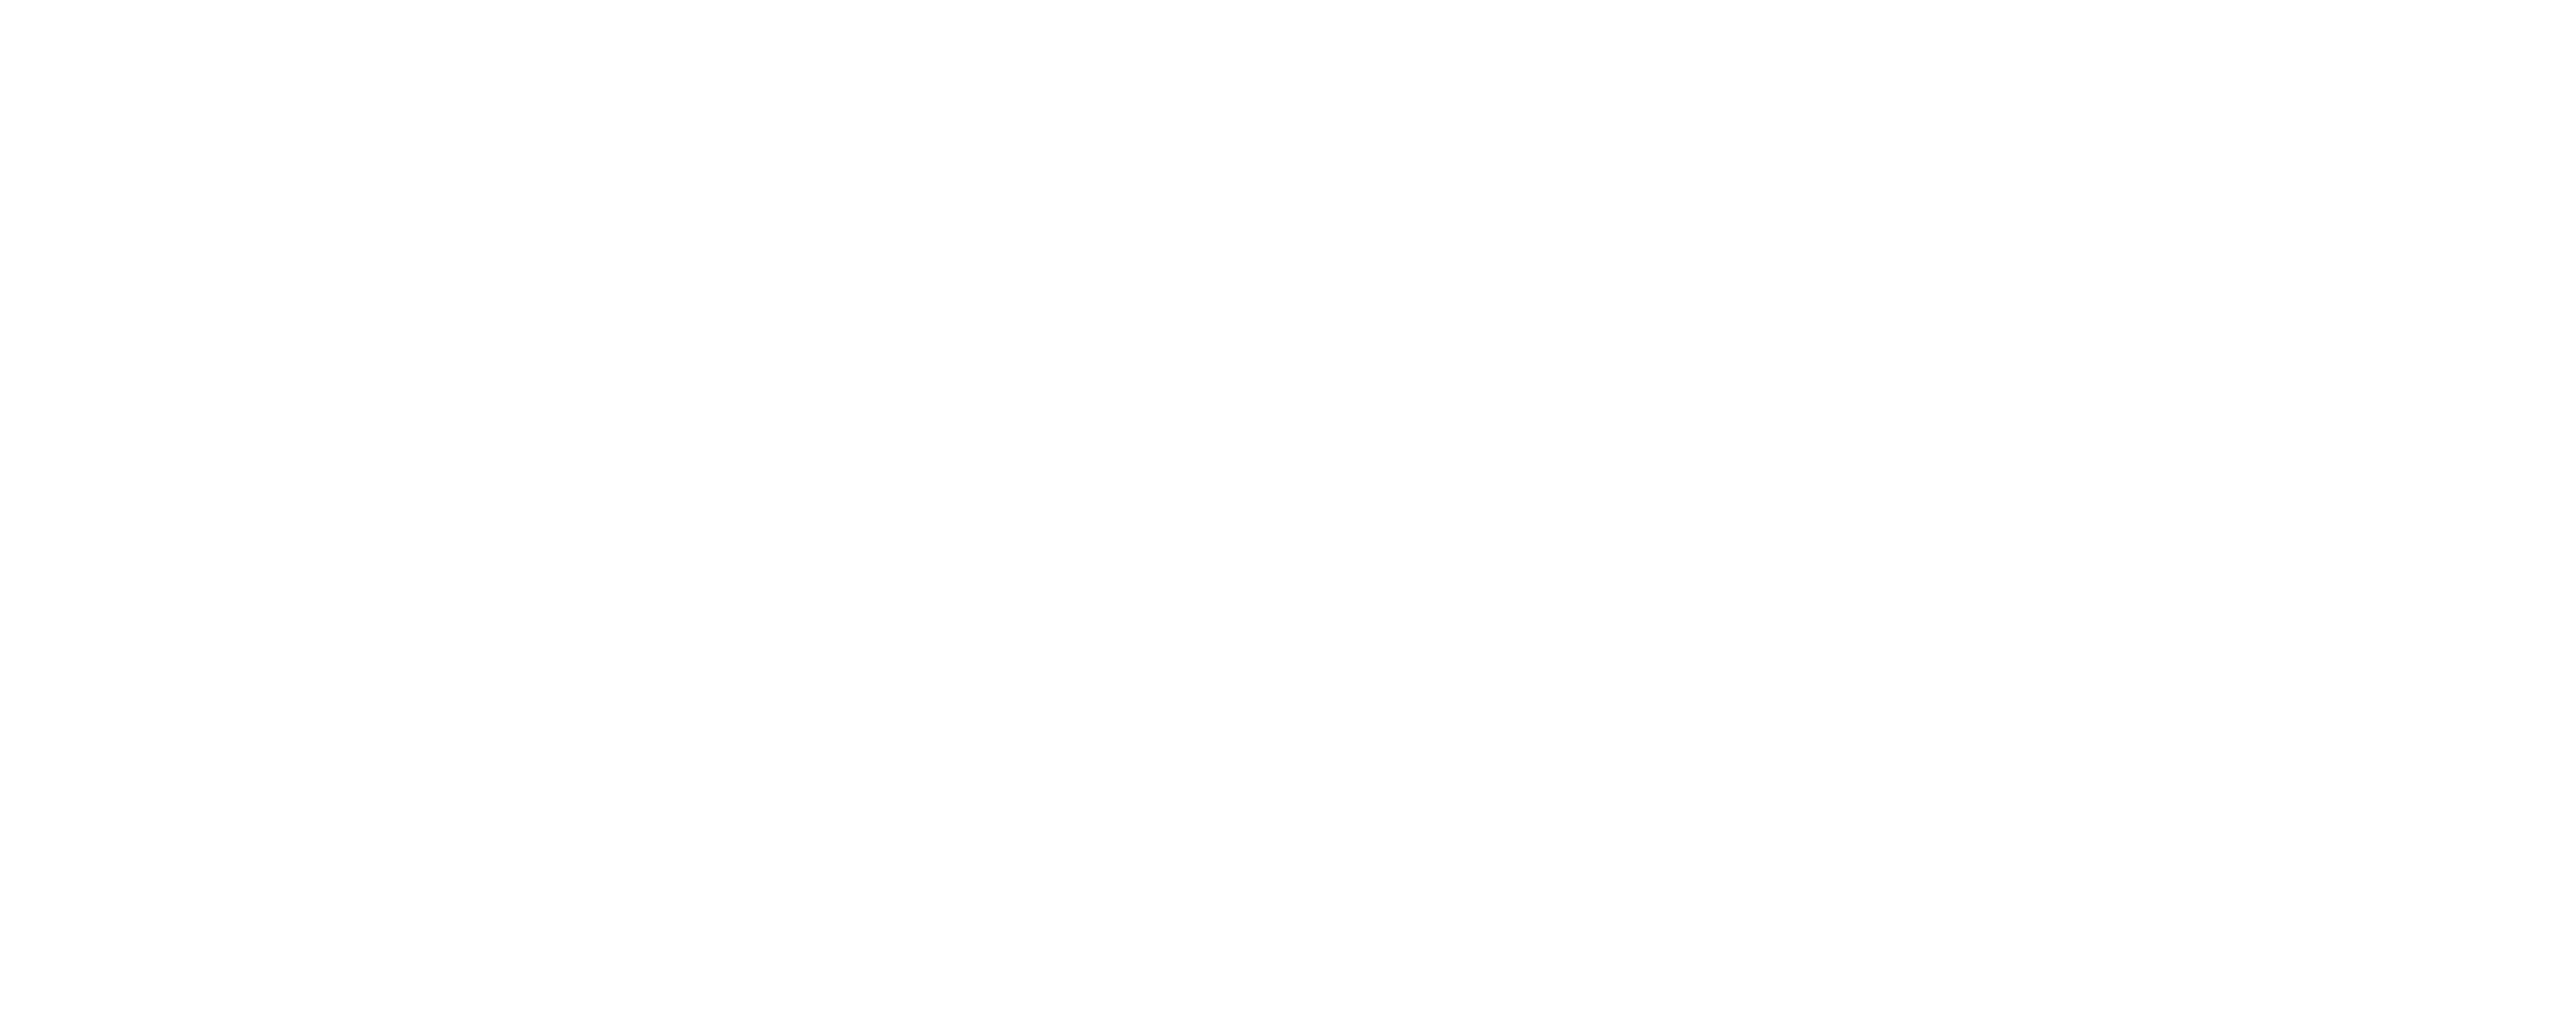

In [155]:
preCOVID <- ggplot() + 
            geom_point(data=data.all[data.all$site == "es1268a" &
                                     data.all$date <= ymd("2020-03-14"), ], aes(x=date, y=no2), color="purple") +
            geom_line(aes(x=data.all[data.all$site == "es1268a" &
                                     data.all$date <= ymd("2020-03-14"), ]$date, 
                          y=y.pre), color="blue") +
            #facet_wrap(~site, ncol=1)

#COVID <- ggplot() + 
            geom_point(data=data.all[data.all$site == "es1268a" &
                                     data.all$date >= ymd("2020-03-14"), ], aes(x=date, y=no2), color="green") +
            geom_line(aes(x=data.all[data.all$site == "es1268a" &
                                     data.all$date >= ymd("2020-03-14"), ]$date, 
                          y=y.drnt), color="darkgreen") + 
            facet_wrap(~site, ncol=1)
    
#grid.arrange(preCOVID, COVID, nrow = 1)
preCOVID

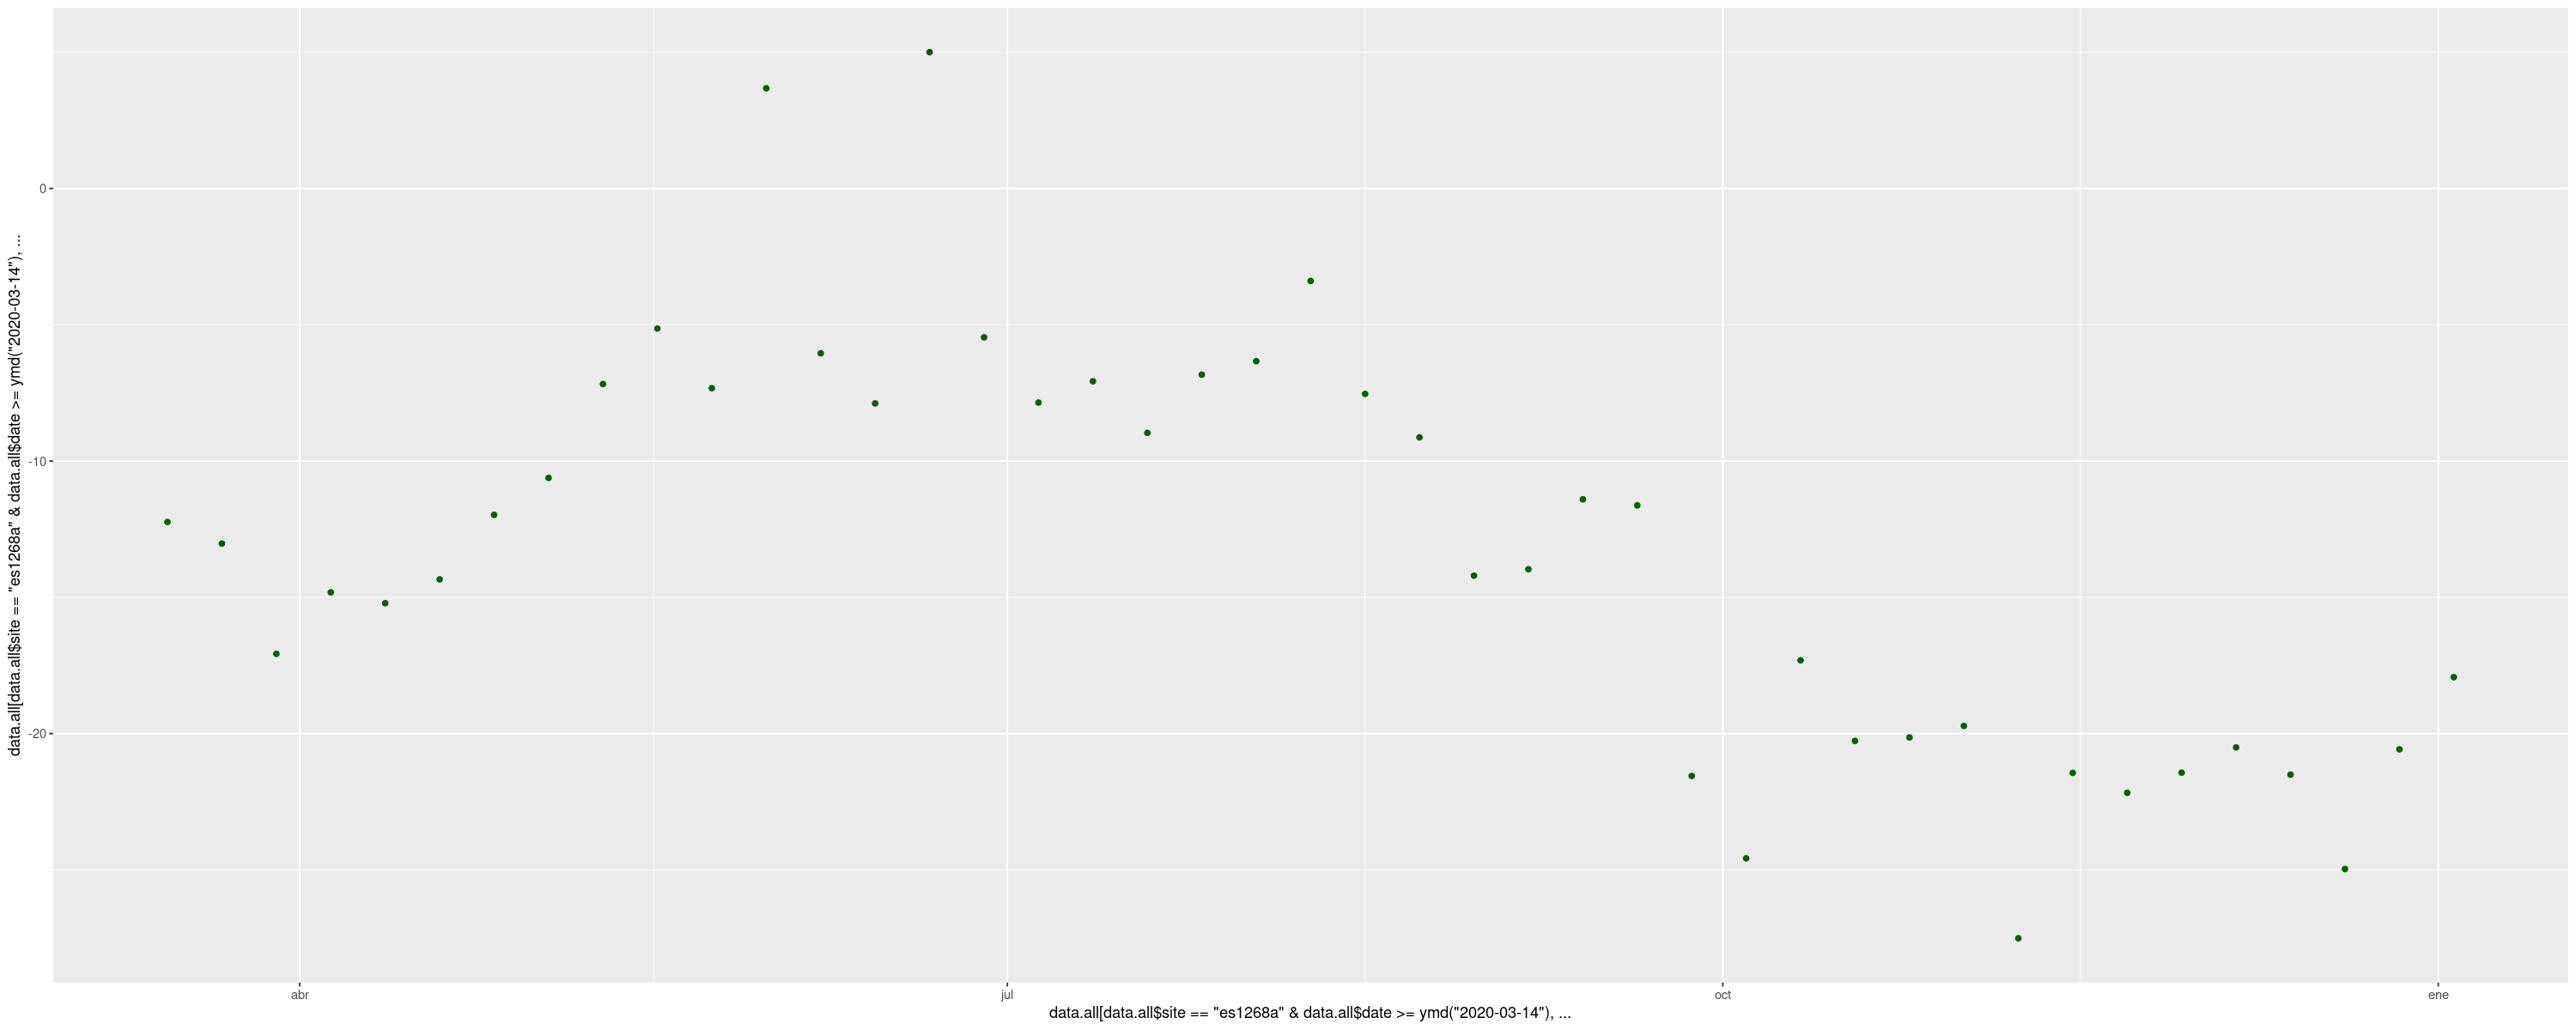

In [70]:
ggplot() + 
    geom_point(aes(x=data.all[data.all$site == "es1268a" &
                                     data.all$date >= ymd("2020-03-14"), ]$date, 
                          y=data.all[data.all$site == "es1268a" &
                                     data.all$date >= ymd("2020-03-14"), ]$no2 - y.drnt
                  ), color="darkgreen")